The following is code I have written for a current project (Jan 2023), reduced and edited for demonstration purposes.  
For this project, I am collaborating with clinical psychologists to study suicide, self-injury, and mental health in adolescents.  
Specifically, this project is exploring the utility of machine learning for predicting self-injurious behaviors and understanding how features contribute to these predictions.  
We are using publicly available data from https://osf.io/8mk6x/  
Prior to reading the data set into this notebook, original data were scored and reformatted.  

# Setup and Preprocessing

## Load code and data

In [1]:
## import code
# basics and plotting
import re
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# preprocessing
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight

# cross-validation and modeling
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

# tuning
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import validation_curve

# staticial comparison of model performance
# see https://github.com/janezd/baycomp
# install library
# pip install baycomp
from baycomp.single import two_on_single

# feature importance
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [2]:
# load data set into a dataframe
data = pd.read_csv("cleaned_cope_data_randomized.csv", dtype={'b_bstad_me_30_days_8': 'str', 'b_bstad_me_90_days_6': 'str', 'b_bstad_me_90_days_8': 'str'})

## Data reduction and exploration

Includes reducing data set to variables of interest; renaming variables; listwise deletion for missing data on target; recoding a categorical feature; and visualizing variable distributions, correlations, and interactions

In [3]:
# general info including rows and columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Columns: 544 entries, Unnamed: 0 to b_uls_tot
dtypes: float64(421), int64(60), object(63)
memory usage: 10.2+ MB


In [4]:
# reduce to columns of interest
# in this example, these include 3 categorical demographic features,
# 9 numeric features of scores on psychological variables,
# and 1 binary target variable indicating whether someone has ever engaged in non-suicidal self-injury
data = data[['b_uls_tot', 'b_cdi_tot', 'b_dem_sex', 'b_dem_gender', 'b_dem_orientation', 
             'b_bads_tot', 'b_shs_tot' , 'b_bhs_tot', 'b_aces_tot' , 'b_mvps_tot', 
             'eds_events_tot', 'b_gad_tot', 'b_sitbi_2']]

# more detail about columns of interest 
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   b_uls_tot          2446 non-null   float64
 1   b_cdi_tot          2448 non-null   float64
 2   b_dem_sex          2452 non-null   object 
 3   b_dem_gender       2452 non-null   object 
 4   b_dem_orientation  2452 non-null   object 
 5   b_bads_tot         2448 non-null   float64
 6   b_shs_tot          2450 non-null   float64
 7   b_bhs_tot          2451 non-null   float64
 8   b_aces_tot         2447 non-null   float64
 9   b_mvps_tot         2447 non-null   float64
 10  eds_events_tot     2448 non-null   float64
 11  b_gad_tot          2447 non-null   float64
 12  b_sitbi_2          2451 non-null   float64
dtypes: float64(10), object(3)
memory usage: 249.2+ KB


In [5]:
# give columns more intuitive names
data.rename(columns = {'b_uls_tot':'loneliness', 'b_cdi_tot':'depression', 'b_dem_sex':'sex',
                        'b_dem_gender':'gender', 'b_dem_orientation':'orientation', 'b_bads_tot':'behav_act',
                        'b_shs_tot':'hope', 'b_bhs_tot':'hopelessness', 'b_aces_tot':'child_adverse',
                        'b_mvps_tot':'peer_vict', 'eds_events_tot':'discrimination', 
                        'b_gad_tot':'anxiety', 'b_sitbi_2':'nssi_bin'}, inplace = True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   loneliness      2446 non-null   float64
 1   depression      2448 non-null   float64
 2   sex             2452 non-null   object 
 3   gender          2452 non-null   object 
 4   orientation     2452 non-null   object 
 5   behav_act       2448 non-null   float64
 6   hope            2450 non-null   float64
 7   hopelessness    2451 non-null   float64
 8   child_adverse   2447 non-null   float64
 9   peer_vict       2447 non-null   float64
 10  discrimination  2448 non-null   float64
 11  anxiety         2447 non-null   float64
 12  nssi_bin        2451 non-null   float64
dtypes: float64(10), object(3)
memory usage: 249.2+ KB


In [6]:
# missing data counts
data.isnull().sum()

loneliness        6
depression        4
sex               0
gender            0
orientation       0
behav_act         4
hope              2
hopelessness      1
child_adverse     5
peer_vict         5
discrimination    4
anxiety           5
nssi_bin          1
dtype: int64

In [7]:
# listwise deletion of samples missing nssi_bin
data = data[data['nssi_bin'].notna()]

# confirming drop of 1 sample
data.shape

(2451, 13)

In [8]:
# how many unique values per outcome
for c in data.columns:
    print(len(data[c].unique()), "unique values in column", c)

58 unique values in column loneliness
26 unique values in column depression
4 unique values in column sex
189 unique values in column gender
10 unique values in column orientation
52 unique values in column behav_act
44 unique values in column hope
14 unique values in column hopelessness
7 unique values in column child_adverse
34 unique values in column peer_vict
51 unique values in column discrimination
23 unique values in column anxiety
2 unique values in column nssi_bin


In [9]:
# preview data
data.head() 

,loneliness,depression,sex,gender,orientation,behav_act,hope,hopelessness,child_adverse,peer_vict,discrimination,anxiety,nssi_bin
0,44.0,21.0,Female,Woman/Girl,Heterosexual/Straight,10.0,13.0,11.0,3.0,14.0,29.0,17.0,1.0
1,33.0,14.0,Female,Woman/Girl,Bisexual,18.0,23.0,7.0,2.0,0.0,34.0,22.0,1.0
2,27.0,9.0,Male,Not sure,Queer,18.0,17.0,7.0,4.0,4.0,32.0,18.0,1.0
3,44.0,11.0,Female,Woman/Girl,Heterosexual/Straight,20.0,26.0,7.0,4.0,5.0,23.0,20.0,0.0
4,27.0,7.0,Female,Woman/Girl,Heterosexual/Straight,28.0,20.0,4.0,1.0,0.0,16.0,11.0,0.0


In [10]:
# look at gender values, which need to be recoded
data['gender'].value_counts()

Woman/Girl                                                                                                      1383
Man/Boy                                                                                                          194
Nonbinary                                                                                                        138
Not sure                                                                                                          78
Man/Boy,Transgender,Female to male transgender/FTM,Trans male/Trans masculine                                     71
                                                                                                                ... 
Woman/Girl,Gender expansive,Androgynous                                                                            1
Female to male transgender/FTM,Androgynous,Nonbinary                                                               1
Man/Boy,Transgender,Female to male transgender/FTM,Trans male/Tr

In [11]:
# recode gender values into 3 mutually exclusive categories
data.loc[data['gender'] == 'Woman/Girl', 'gender'] = 'woman_only'
data.loc[data['gender'] == 'Man/Boy', 'gender'] = 'man_only'
data.loc[(data['gender'] != 'man_only') & (data['gender'] != 'woman_only'), 'gender'] = 'gender_diverse'

In [12]:
# verify recoding results
data['gender'].value_counts()

woman_only        1383
gender_diverse     874
man_only           194
Name: gender, dtype: int64

### Features: numeric

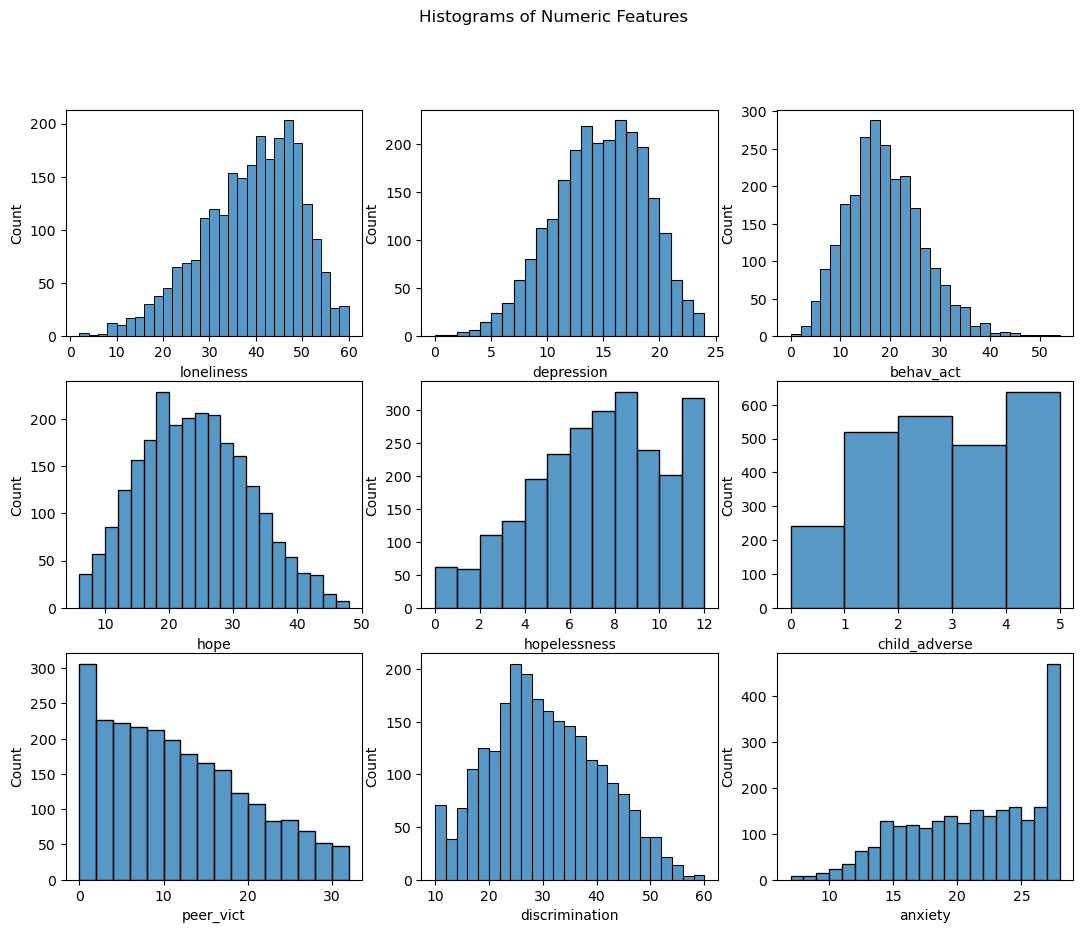

In [13]:
# histograms of numeric features
fig, axes = plt.subplots(3, 3, figsize=(13, 10))
fig.suptitle('Histograms of Numeric Features')

sns.histplot(ax=axes[0, 0], data=data['loneliness'], binwidth=2)
sns.histplot(ax=axes[0, 1], data=data['depression'], binwidth=1)
sns.histplot(ax=axes[0, 2], data=data['behav_act'], binwidth=2)
sns.histplot(ax=axes[1, 0], data=data['hope'], binwidth=2)
sns.histplot(ax=axes[1, 1], data=data['hopelessness'], binwidth=1)
sns.histplot(ax=axes[1, 2], data=data['child_adverse'], binwidth=1)
sns.histplot(ax=axes[2, 0], data=data['peer_vict'], binwidth=2)
sns.histplot(ax=axes[2, 1], data=data['discrimination'], binwidth=2)
sns.histplot(ax=axes[2, 2], data=data['anxiety'], binwidth=1)

# don't show unnecessary output about object
None

In [14]:
# examine correlations between numeric features
numeric_features = ['loneliness', 'depression', 'behav_act', 'hope', 'hopelessness', 
                    'child_adverse', 'peer_vict', 'discrimination', 'anxiety']
data[numeric_features].corr()

,loneliness,depression,behav_act,hope,hopelessness,child_adverse,peer_vict,discrimination,anxiety
loneliness,1.000000,0.550011,-0.478647,-0.423158,0.508124,0.225473,0.272284,0.347911,0.380203
depression,0.550011,1.000000,-0.643446,-0.563095,0.634688,0.302187,0.322832,0.433894,0.564212
behav_act,-0.478647,-0.643446,1.000000,0.580059,-0.531347,-0.283846,-0.244080,-0.334728,-0.440418
hope,-0.423158,-0.563095,0.580059,1.000000,-0.594862,-0.189588,-0.175221,-0.238655,-0.274598
hopelessness,0.508124,0.634688,-0.531347,-0.594862,1.000000,0.172272,0.268169,0.340686,0.415289
child_adverse,0.225473,0.302187,-0.283846,-0.189588,0.172272,1.000000,0.263421,0.341760,0.268789
peer_vict,0.272284,0.322832,-0.244080,-0.175221,0.268169,0.263421,1.000000,0.625618,0.342707
discrimination,0.347911,0.433894,-0.334728,-0.238655,0.340686,0.341760,0.625618,1.000000,0.421275
anxiety,0.380203,0.564212,-0.440418,-0.274598,0.415289,0.268789,0.342707,0.421275,1.000000


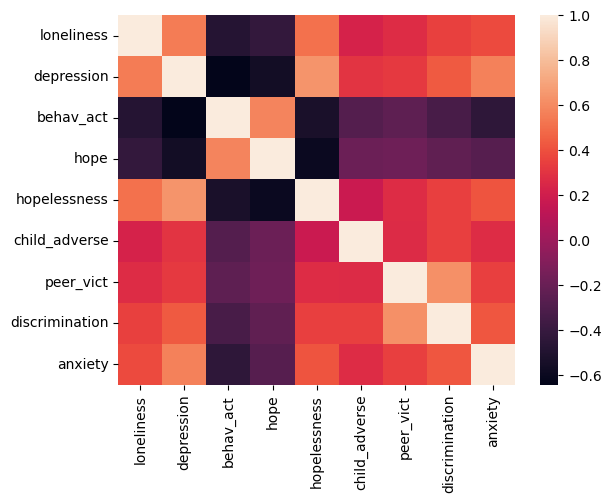

In [15]:
# visualize correlations
sns.heatmap(data[numeric_features].corr())
None

We can see some expected relationships.   
Strong correlations between loneliness, hopelessness, depression, and anxiety  
These tend to be inversely related to behavioral activation and hope.  
Also strong correlation between discrimination and peer victimization  

### Features: categorical

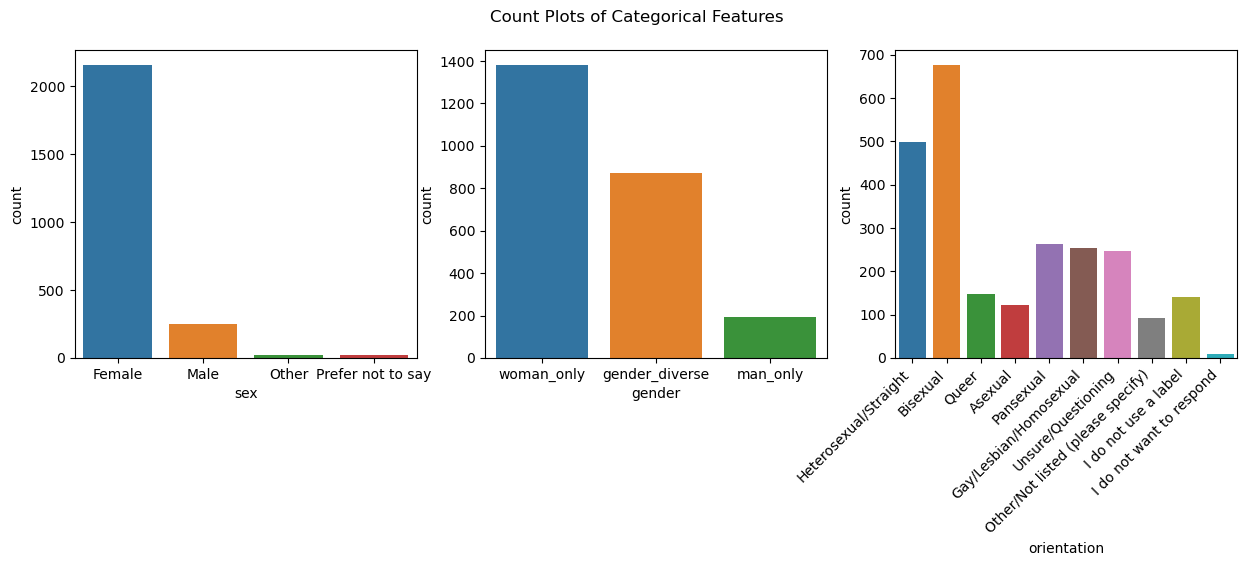

In [16]:
# count plots of categorical features
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Count Plots of Categorical Features')

sns.countplot(ax=axes[0], x=data['sex'])

sns.countplot(ax=axes[1], x=data['gender'])

sns.countplot(ax=axes[2], x=data['orientation'])

plt.xticks(rotation=45, horizontalalignment='right')
None

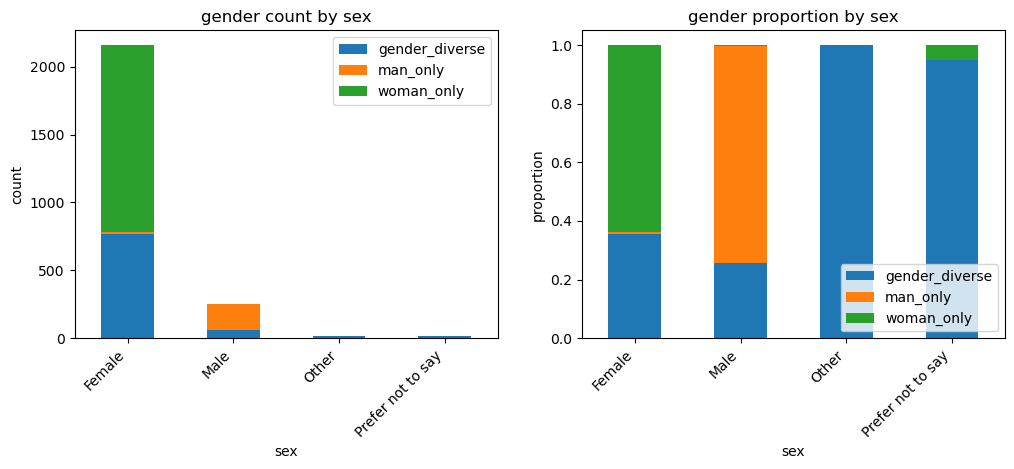

In [17]:
# examining distribution of gender by sex
cross_tab_sex_gender = pd.crosstab(index=data['sex'], columns=data['gender'])
cross_tab_sex_gender_norm = pd.crosstab(index=data['sex'], columns=data['gender'], normalize="index")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cross_tab_sex_gender.plot(ax=axes[0], kind='bar', stacked=True)
axes[0].legend(loc="upper right", ncol=1)
axes[0].set_xlabel("sex")
axes[0].set_ylabel("count")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_title("gender count by sex")

cross_tab_sex_gender_norm.plot(ax=axes[1], kind='bar', stacked=True)
axes[1].legend(loc="lower right", ncol=1)
axes[1].set_xlabel("sex")
axes[1].set_ylabel("proportion")
axes[1].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[1].set_title("gender proportion by sex")

None

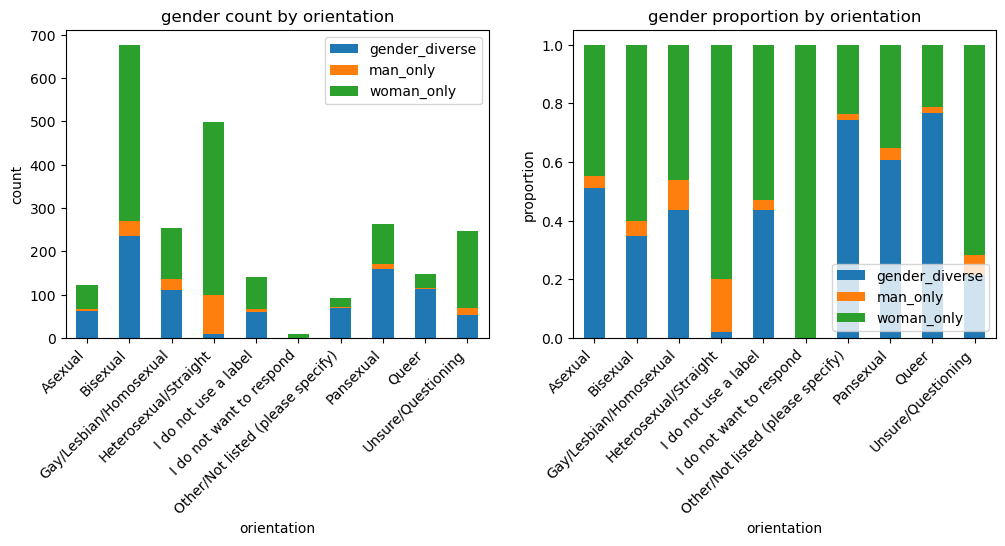

In [18]:
# examining distribution of gender by orientation
cross_tab_orient_gender = pd.crosstab(index=data['orientation'], columns=data['gender'])
cross_tab_orient_gender_norm = pd.crosstab(index=data['orientation'], columns=data['gender'], normalize="index")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cross_tab_orient_gender.plot(ax=axes[0], kind='bar', stacked=True)
axes[0].legend(loc="upper right", ncol=1)
axes[0].set_xlabel("orientation")
axes[0].set_ylabel("count")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_title("gender count by orientation")

cross_tab_orient_gender_norm.plot(ax=axes[1], kind='bar', stacked=True)
axes[1].legend(loc="lower right", ncol=1)
axes[1].set_xlabel("orientation")
axes[1].set_ylabel("proportion")
axes[1].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[1].set_title("gender proportion by orientation")

None

These plots help to demonstrate that each of these demographic features contributes unique information.

### Target

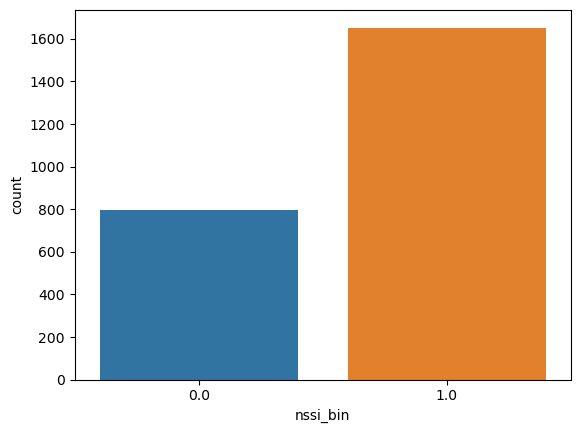

In [19]:
# count plot of categorical target variable
sns.countplot(x=data['nssi_bin'])
None

# Modeling

Includes preprocessing, missing data imputation, hyperparameter tuning, 
and modeling with logistic regression, random forest, and gradient boosting decision tree models.

In [20]:
# define target
target = data['nssi_bin']

# define features
features = data[['loneliness', 'depression', 'sex', 'gender', 'orientation', 'behav_act',
                   'hope', 'hopelessness', 'child_adverse', 'peer_vict', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer for missing data in numeric features
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)

## Logistic regression

In [21]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [22]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
logreg_pipeline = make_pipeline(preprocessor, imputer, logreg)

In [23]:
# hyperparameter tuning
# hyperparameter values to try
param_grid =  {
    'logisticregression__C': [0.1, 0.5, 1, 2, 5, 10]}

grid_search = GridSearchCV(logreg_pipeline, param_grid=param_grid, n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, return_estimator=True)

In [24]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'logisticregression__C': 0.1}
with accuracy of 0.705
Best hyperparameters for split #2:
{'logisticregression__C': 0.1}
with accuracy of 0.684
Best hyperparameters for split #3:
{'logisticregression__C': 0.5}
with accuracy of 0.692
Best hyperparameters for split #4:
{'logisticregression__C': 0.1}
with accuracy of 0.708
Best hyperparameters for split #5:
{'logisticregression__C': 0.1}
with accuracy of 0.690


0.1 is probably best, but let's examine validation curve

In [25]:
# generate validation curve for n_estimators
C_values = [0.01, 0.1, 0.3, 0.5, 0.8, 1, 2]
train_scores, test_scores = validation_curve(
    logreg_pipeline, features, target, param_name='logisticregression__C', param_range=C_values, 
    scoring='accuracy', n_jobs=2)

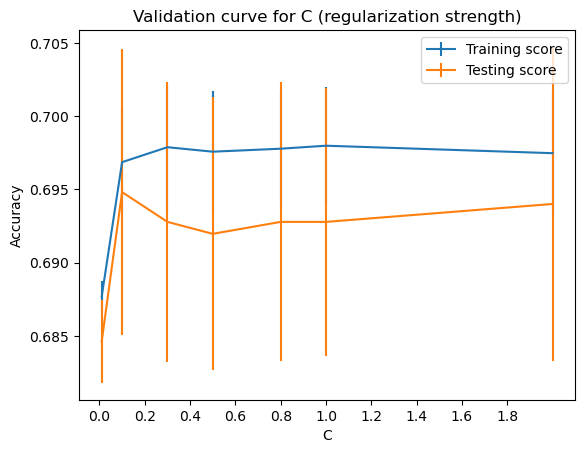

In [26]:
# plot validation curve for n_estimators
plt.errorbar(C_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(C_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 2, 0.2))
plt.xlabel("C")
plt.ylabel("Accuracy")
_ = plt.title("Validation curve for C (regularization strength)")

Yes, C of 0.1 looks good.

In [27]:
# set C to 0.1
logreg_pipeline.set_params(logisticregression__C=0.1)

# get results from tuned model
logreg_results = cross_validate(logreg_pipeline, features, target, cv=cross_val)

In [28]:
print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_score"].mean():.3f} +/- {logreg_results["test_score"].std():.3f}') 

The mean accuracy with cross-validation is: 0.690 +/- 0.030


## Random forest

In [29]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [30]:
# hyperparameter tuning
# define algorithm
rfc = RandomForestClassifier(n_jobs=2, random_state=0, class_weight='balanced')

# assemble steps into pipeline
rfc_pipeline = make_pipeline(preprocessor, imputer, rfc)

# hyperparameter values to try
param_grid =  {
    'randomforestclassifier__n_estimators': [100, 500, 1000], 
    'randomforestclassifier__max_leaf_nodes': [8, 16, 32, 64, 128, 256]}

grid_search = GridSearchCV(rfc_pipeline, param_grid=param_grid, n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, return_estimator=True)

In [31]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'randomforestclassifier__max_leaf_nodes': 128, 'randomforestclassifier__n_estimators': 100}
with accuracy of 0.703
Best hyperparameters for split #2:
{'randomforestclassifier__max_leaf_nodes': 256, 'randomforestclassifier__n_estimators': 500}
with accuracy of 0.698
Best hyperparameters for split #3:
{'randomforestclassifier__max_leaf_nodes': 256, 'randomforestclassifier__n_estimators': 100}
with accuracy of 0.724
Best hyperparameters for split #4:
{'randomforestclassifier__max_leaf_nodes': 256, 'randomforestclassifier__n_estimators': 500}
with accuracy of 0.733
Best hyperparameters for split #5:
{'randomforestclassifier__max_leaf_nodes': 256, 'randomforestclassifier__n_estimators': 500}
with accuracy of 0.708


max_leaf_nodes was consistently best at 256, while n_estimators varied.  
Will examine n_estimators further below.

In [32]:
# generate validation curve for n_estimators
n_estimators_values = [100, 200, 500, 750, 1000]
rfc_pipeline.set_params(randomforestclassifier__max_leaf_nodes=256)
train_scores, test_scores = validation_curve(
    rfc_pipeline, features, target, param_name='randomforestclassifier__n_estimators', 
    param_range=n_estimators_values, scoring='accuracy', n_jobs=2)

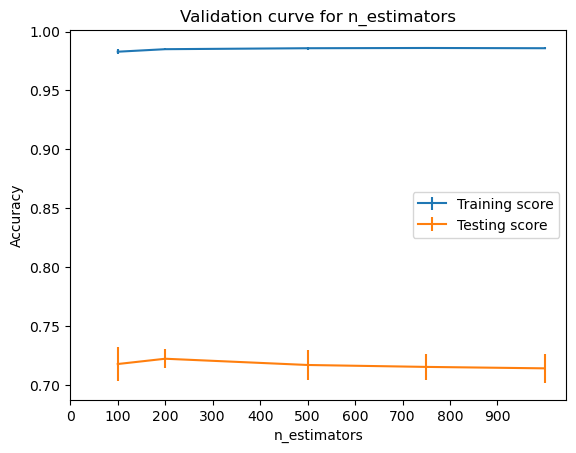

In [33]:
# plot validation curve for n_estimators
plt.errorbar(n_estimators_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(n_estimators_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 1000, 100))
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
_ = plt.title("Validation curve for n_estimators")

200 looks best for n_estimators.

In [34]:
# set n_estimators to 200
rfc_pipeline.set_params(randomforestclassifier__n_estimators=200)

# get results from tuned model
rfc_results = cross_validate(rfc_pipeline, features, target, cv=cross_val)

In [35]:
print('The mean accuracy with cross-validation is: ' 
      f'{rfc_results["test_score"].mean():.3f} +/- {rfc_results["test_score"].std():.3f}') 

The mean accuracy with cross-validation is: 0.714 +/- 0.026


## Gradient boosting decision trees

In [36]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [37]:
# hyperparameter tuning

# have to manually adjust weights to correct for class imbalance
# since HistGradientBoostingClassifier doesn't have a built-in class_weight parameter
sample_weights = compute_sample_weight(class_weight='balanced', y=target)

# define algorithm
hgbc = HistGradientBoostingClassifier(random_state=0, categorical_features=[0,1,2], learning_rate=0.1)

# assemble steps into pipeline
hgbc_pipeline = make_pipeline(preprocessor, imputer, hgbc)

# hyperparameter values to try
param_grid =  {
    'histgradientboostingclassifier__max_iter': [50, 100, 150, 200],
    'histgradientboostingclassifier__max_leaf_nodes': [8, 16, 32, 64, 128, 256]}

grid_search = GridSearchCV(hgbc_pipeline, param_grid=param_grid, n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, 
                            fit_params={'histgradientboostingclassifier__sample_weight': sample_weights}, 
                            return_estimator=True)

In [38]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 64}
with accuracy of 0.692
Best hyperparameters for split #2:
{'histgradientboostingclassifier__max_iter': 100, 'histgradientboostingclassifier__max_leaf_nodes': 64}
with accuracy of 0.673
Best hyperparameters for split #3:
{'histgradientboostingclassifier__max_iter': 100, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with accuracy of 0.694
Best hyperparameters for split #4:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 64}
with accuracy of 0.686
Best hyperparameters for split #5:
{'histgradientboostingclassifier__max_iter': 200, 'histgradientboostingclassifier__max_leaf_nodes': 128}
with accuracy of 0.722


Let's examine max_iter while holding max_leaf_nodes at 64. 

In [39]:
# set tuned hyperparameters
hgbc_pipeline.set_params(histgradientboostingclassifier__max_leaf_nodes=64)

# generate validation curve for max_iter
max_iter_values = [50, 100, 150, 200, 250]
train_scores, test_scores = validation_curve(
    hgbc_pipeline, features, target, param_name='histgradientboostingclassifier__max_iter', 
    param_range=max_iter_values, scoring='accuracy', n_jobs=2)

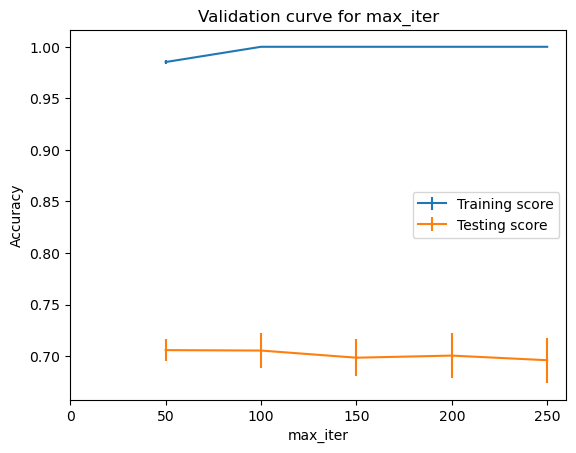

In [40]:
# plot validation curve for max_iter
plt.errorbar(max_iter_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_iter_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 300, 50))
plt.xlabel("max_iter")
plt.ylabel("Accuracy")
_ = plt.title("Validation curve for max_iter")

max_iter of 50 appears sufficient

In [41]:
# set tuned hyperparameters
hgbc_pipeline.set_params(histgradientboostingclassifier__max_iter=50)

# get results from tuned model
hgbc_results = cross_validate(hgbc_pipeline, features, target, cv=cross_val,
                             fit_params={'histgradientboostingclassifier__sample_weight': sample_weights})

In [43]:
print('The mean accuracy with cross-validation is: ' 
      f'{hgbc_results["test_score"].mean():.3f} +/- {hgbc_results["test_score"].std():.3f}') 

The mean accuracy with cross-validation is: 0.693 +/- 0.027


# Interpretation

Includes defining functions to compute permutation feature importance and feature rank instability, 
visualizing feature importances, and comparing performance between models using Bayesian correlated t tests.

## Permutation feature importance

In [44]:
# compute permutation feature importances
# perm_n: number of iterations of permutation feature importance procedure to aggregate
def perm_feat_imp(pipeline, perm_n=25):
    
    # create dataframe to store results
    perm_results_df = pd.DataFrame(index=features.columns, columns=range(perm_n))
    
    for i in range(perm_n):

        # split data for permutation importance computation
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

        # permutation importance computation
        pipeline.fit(X_train, y_train)
        perm_results = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=0, n_jobs=2)

        # store results in a dataframe and sort
        perm_results_df.iloc[:, i] = perm_results.importances_mean
        
    # summarize results over iterations
    perm_results_summary = pd.DataFrame(index=features.columns)
    perm_results_summary['mean'] = perm_results_df.mean(axis=1)
    perm_results_summary['std'] = perm_results_df.std(axis=1)
    perm_results_summary.sort_values('mean', ascending=False, inplace=True)
    
    return perm_results_df, perm_results_summary

In [45]:
# compute feature rank instability
# how much feature rank changes over aggregations of successively larger number of permutation importance iterations
def rank_instability(perm_results_df):
    instability = pd.Series(index=range(2,26), dtype='float')
    
    # compute feature rank instability between 1st iteration and the aggregation of the 1st 2 iterations
    agg1 = perm_results_df.iloc[:, 0].rank(ascending=False)
    agg2 = perm_results_df.iloc[:, 0:2].mean(axis=1).rank(ascending=False)
    instability[2] = abs(agg2 - agg1).mean()
    
    # compute feature rank instability between successive aggregations
    for i in range(3,26):
        agg1 = perm_results_df.iloc[:, 0:(i-1)].mean(axis=1).rank(ascending=False)
        agg2 = perm_results_df.iloc[:, 0:i].mean(axis=1).rank(ascending=False)
        instability[i] = abs(agg2 - agg1).mean()
        
    return instability

                    mean       std
depression      0.022110  0.012307
orientation     0.015804  0.007592
sex             0.010916  0.007571
child_adverse   0.009955  0.008619
gender          0.009043  0.007048
discrimination  0.005809  0.009044
hope            0.003487  0.006705
anxiety         0.000912  0.006646
behav_act      -0.000815  0.004211
hopelessness   -0.001018  0.003757
loneliness     -0.002460  0.003931
peer_vict      -0.002933  0.004776


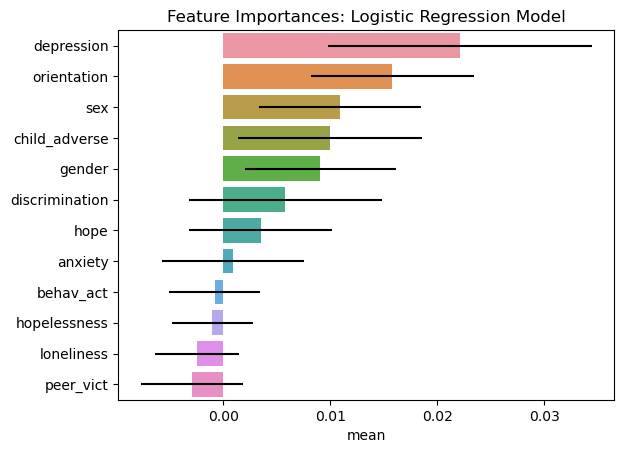

In [46]:
## logistic regression
logreg_importance_full, logreg_importance_summary = perm_feat_imp(logreg_pipeline)    
    
# view results
print(logreg_importance_summary)
plt.title("Feature Importances: Logistic Regression Model")
sns.barplot(x=logreg_importance_summary['mean'], y=logreg_importance_summary.index, 
            xerr=logreg_importance_summary['std'])

None

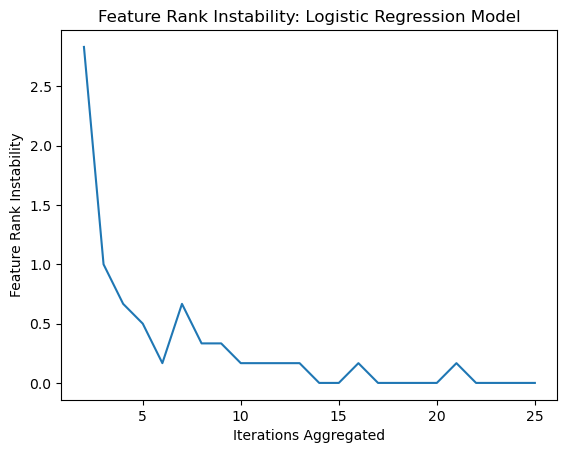

In [47]:
# feature rank instability plot
logreg_instability = rank_instability(logreg_importance_full)
  
plt.plot(logreg_instability.index, logreg_instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability: Logistic Regression Model")
None

Feature rank instability has generally stabilized by aggregating 25 iterations of permutation feature importance.

                    mean       std
depression      0.021898  0.010026
child_adverse   0.012041  0.006534
gender          0.006037  0.006364
discrimination  0.002004  0.007547
hopelessness    0.000318  0.006681
peer_vict       0.000163  0.006080
anxiety        -0.000057  0.008055
sex            -0.000196  0.002585
behav_act      -0.000538  0.007149
loneliness     -0.000953  0.007963
hope           -0.001540  0.005715
orientation    -0.001955  0.005637


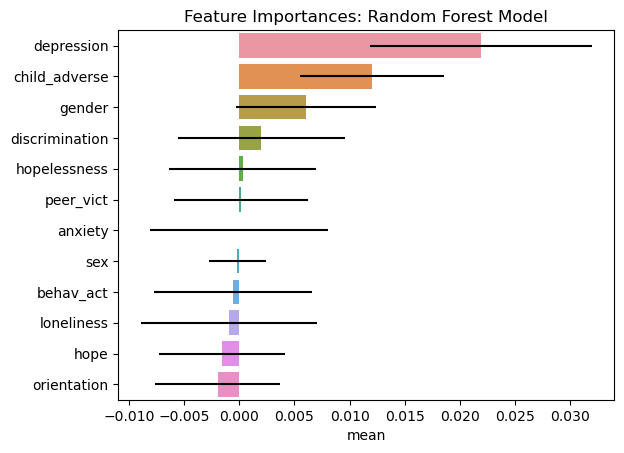

In [48]:
## random forest
rfc_importance_full, rfc_importance_summary = perm_feat_imp(rfc_pipeline)    
    
# view results
print(rfc_importance_summary)
plt.title("Feature Importances: Random Forest Model")
sns.barplot(x=rfc_importance_summary['mean'], y=rfc_importance_summary.index, xerr=rfc_importance_summary['std'])

None

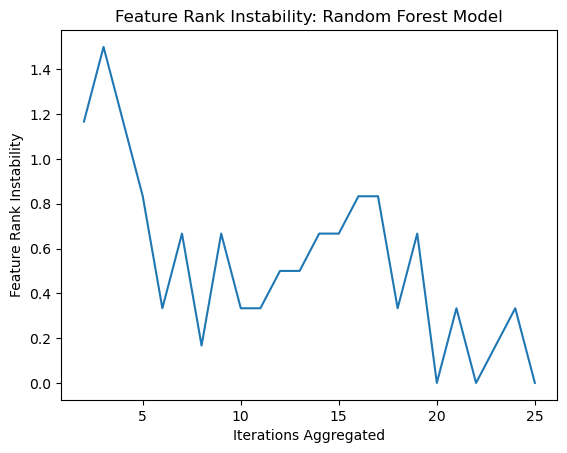

In [49]:
# feature rank instability plot
rfc_instability = rank_instability(rfc_importance_full)
  
plt.plot(rfc_instability.index, rfc_instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability: Random Forest Model")
None

                    mean       std
depression      0.024945  0.011976
child_adverse   0.013328  0.008913
orientation     0.010941  0.010619
discrimination  0.007405  0.010635
loneliness      0.007242  0.010962
gender          0.006444  0.006440
peer_vict       0.005532  0.009865
sex             0.003984  0.005969
behav_act       0.003894  0.008709
hopelessness    0.003731  0.008715
hope            0.003576  0.009533
anxiety         0.003063  0.010621


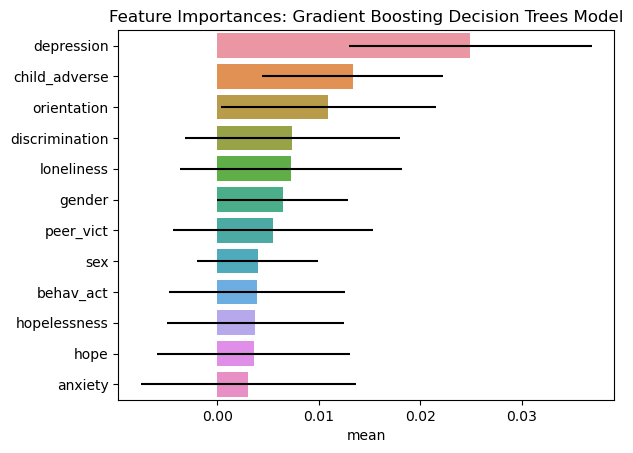

In [50]:
## gradient boosting decision trees
hgbc_importance_full, hgbc_importance_summary = perm_feat_imp(hgbc_pipeline)    
    
# view results
print(hgbc_importance_summary)
plt.title("Feature Importances: Gradient Boosting Decision Trees Model")
sns.barplot(x=hgbc_importance_summary['mean'], y=hgbc_importance_summary.index, xerr=hgbc_importance_summary['std'])

None

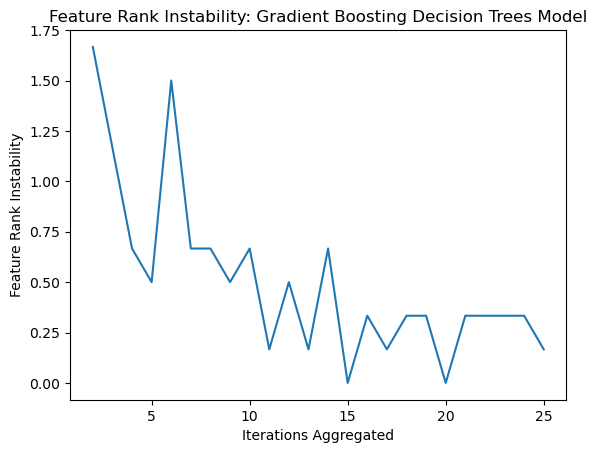

In [51]:
# feature rank instability plot
hgbc_instability = rank_instability(hgbc_importance_full)
  
plt.plot(hgbc_instability.index, hgbc_instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability: Gradient Boosting Decision Trees Model")
None

## Model comparisons

((0.0001677119008604546, 0.06452813878867725, 0.9353041493104624), <Figure size 640x480 with 1 Axes>)


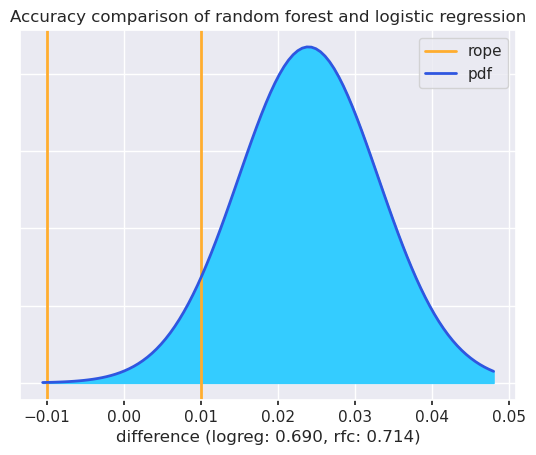

In [52]:
# statistical tests comparing performance
rfc_vs_logreg = two_on_single(x=logreg_results["test_score"], y=rfc_results["test_score"], 
                                rope=0.01, runs=10, names=('logreg', 'rfc'), plot=True)
plt.title("Accuracy comparison of random forest and logistic regression")
print(rfc_vs_logreg)

We define that two models are practically equivalent if their accuracies are within 1 percentage point.  
These results indicate a 94% probability that the accuracy of the random forest classifier is greater than the accuracy of the logistic regression model.

((0.05588502008680088, 0.7693121723767682, 0.17480280753643096), <Figure size 640x480 with 1 Axes>)


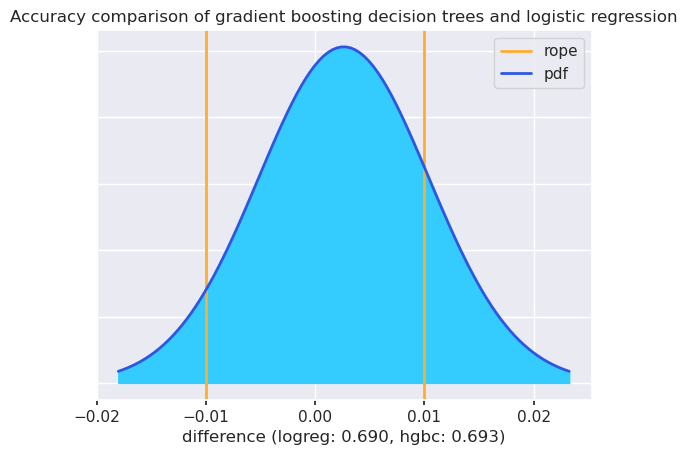

In [53]:
hgbc_vs_logreg = two_on_single(x=logreg_results["test_score"], y=hgbc_results["test_score"], 
                                rope=0.01, runs=10, names=('logreg', 'hgbc'), plot=True)
plt.title("Accuracy comparison of gradient boosting decision trees and logistic regression")
print(hgbc_vs_logreg)

There's a 77% probability that the accuracies of the gradient boosting decision trees and 
logistic regression models are equivalent.

((7.930265759042053e-05, 0.0787082071837506, 0.921212490158659), <Figure size 640x480 with 1 Axes>)


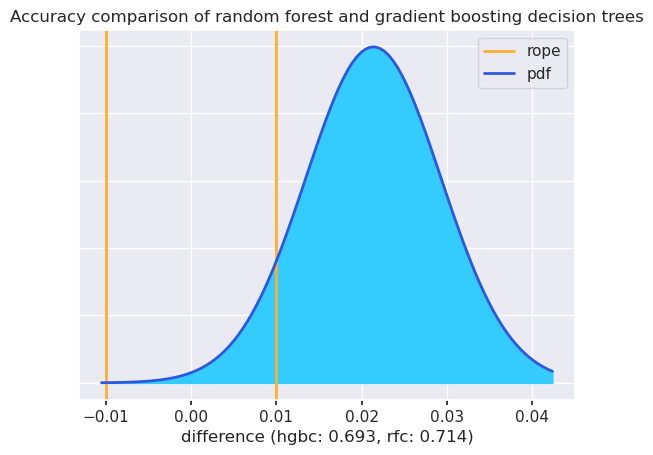

In [54]:
rfc_vs_hgbc = two_on_single(x=hgbc_results["test_score"], y=rfc_results["test_score"], 
                                rope=0.01, runs=10, names=('hgbc', 'rfc'), plot=True)
plt.title("Accuracy comparison of random forest and gradient boosting decision trees")
print(rfc_vs_hgbc)

These results indicate a 92% probability that the accuracy of the random forest classifier is greater 
than the accuracy of the gradient boosting decision trees model.

The random forest model seemed to perform a little better than the other two models.  
Overall, though, all three models highlight higher levels of depression, followed by greater childhood adversity, as predictors of non-suicidal self-injury. 
To varying degrees, these models also highlight demographic features related to gender and sexuality as predictors of non-suicidal self-injury.